# **Volatility Smile and Surface**

In [1]:
# Import packages
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as si
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
from datetime import datetime as dt

### Data importation and time to maturity

In [2]:
# First, we create a function to import the option data
def data_option(ticker,expiration) :
    asset_ticker = yf.Ticker(ticker)    
    option_data = pd.DataFrame()
    opt = asset_ticker.option_chain(expiration)
    calls = opt.calls
    calls["opt_type"] = "call"
    puts = opt.puts
    puts["opt_type"] = "put"
    
    # Concatening calls and puts : 
    option_data = pd.concat([calls,puts])

    # Formating expiration and adding days until expiration (we consider 365 days by year) : 
    option_data["expiration"] = pd.to_datetime(expiration) \
        + pd.DateOffset(hours = 23, minutes = 59, seconds=59)   
    option_data["days_to_exp"] = ((option_data.expiration - dt.today()).dt.days)/365  
    
    return option_data

In [4]:
aapl_option = data_option("AAPL",'2024-05-17')
aapl_option.head()
# We can see that there is already an implied volatility, as the purpose of this notebook is to explore it, we will re-compute
# it following BS approach.

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,opt_type,expiration,days_to_exp
0,AAPL240517C00005000,2024-05-09 17:44:51+00:00,5.0,177.71,177.5,178.40,-1.689987,-0.942022,1.0,0,14.132814,True,REGULAR,USD,call,2024-05-17 23:59:59,0.013699
1,AAPL240517C00010000,2024-05-03 18:15:51+00:00,10.0,172.72,172.6,173.40,-2.970001,-1.690478,1.0,0,10.968753,True,REGULAR,USD,call,2024-05-17 23:59:59,0.013699
2,AAPL240517C00020000,2024-05-09 17:44:51+00:00,20.0,164.50,162.6,163.40,0.000000,0.000000,100.0,0,8.156255,True,REGULAR,USD,call,2024-05-17 23:59:59,0.013699
3,AAPL240517C00025000,2024-05-09 17:44:51+00:00,25.0,159.40,157.6,158.45,0.000000,0.000000,45.0,0,7.453126,True,REGULAR,USD,call,2024-05-17 23:59:59,0.013699
4,AAPL240517C00035000,2024-04-15 14:03:44+00:00,35.0,139.72,147.6,148.45,0.000000,0.000000,NaN,0,6.183596,True,REGULAR,USD,call,2024-05-17 23:59:59,0.013699


In [5]:
# We will need model for both put and call pricing (detailled approach in the option pricing notebook)
def BS_call(S, K, T, r, sigma) :
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T)\
    / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T)\
    / (sigma * np.sqrt(T))
    result = (S * si.norm.cdf(d1 , 0.0 , 1.0)- K * np.exp(-r * T)\
        * si.norm.cdf(d2 , 0.0 , 1.0))
    return result

def BS_put(S, K, T, r, sigma) :
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T)\
    / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T)\
    / (sigma * np.sqrt(T))
    result = (K * np.exp(-r * T) * si.norm.cdf(-d2 , 0.0 , 1.0)- S \
        * si.norm.cdf(-d1 , 0.0 , 1.0))
    return result

### Implied volatility calculation

In [6]:
# We considere the price furnished by yahoofinance as right, so we will solve the BS formula with only the volatility as unknown.
def get_iv(otype, S, K, T, r, last) : 
    
    if otype == "call" :    
        def call_iv(sigma) : 
            return BS_call(S, K, T, r, sigma) - last
        
        try : 
            iv = optimize.brentq(call_iv, 0.001, 3, xtol=1e-6)
            print("call",S,K,T,r,last)
        except : 
           return np.nan 
    else :
        
        def put_iv(sigma) : 
            return BS_put(S, K, T, r, sigma) - last
        
        try :
            iv = optimize.brentq(put_iv, 0.001, 3, xtol=1e-6)
            print("put",S,K,T,r,last)
        except : 
           return np.nan 
    return iv

In [7]:
def main() :
    option_chains = pd.DataFrame()
    ticker ="AAPL"
    asset_ticker = yf.Ticker(ticker)
    opt_types = ["call","put"]
    
    # Define BS parameter
    S = asset_ticker.history(period="1d")["Close"].iloc[-1] # Spot price
    r = 0.0525  # We consider the current FED fund rate
    expirations = asset_ticker.options # List of expiration option avaible
    
    for expiration in expirations :
        temp = data_option(ticker,expiration)
        option_chains = pd.concat([option_chains,temp])
    
    option_chains = option_chains.reset_index()
    option_chains['IV'] = 0
 
    # Computing IV for each contract
    for symbol in option_chains['contractSymbol'].unique() :
        try : 
            last = option_chains[(option_chains['contractSymbol']==symbol)]['lastPrice'].values[0]
            K = option_chains[(option_chains['contractSymbol']==symbol)]['strike'].values[0]
            T = option_chains[(option_chains['contractSymbol']==symbol)]['days_to_exp'].values[0]
            otype = option_chains[(option_chains['contractSymbol']==symbol)]['opt_type'].values[0]
            option_chains.loc[(option_chains['contractSymbol']==symbol),'IV'] = get_iv(otype, S, K, T, r, last)
        except :
            pass
        
    return ticker, option_chains

In [8]:
ticker, option_def = main()

call 183.0500030517578 115.0 0.0136986301369863 0.0525 68.69
call 183.0500030517578 120.0 0.0136986301369863 0.0525 64.33
call 183.0500030517578 140.0 0.0136986301369863 0.0525 43.23
call 183.0500030517578 145.0 0.0136986301369863 0.0525 38.25
call 183.0500030517578 152.5 0.0136986301369863 0.0525 32.45
call 183.0500030517578 155.0 0.0136986301369863 0.0525 29.53
call 183.0500030517578 160.0 0.0136986301369863 0.0525 23.37
call 183.0500030517578 165.0 0.0136986301369863 0.0525 18.33
call 183.0500030517578 167.5 0.0136986301369863 0.0525 15.77
call 183.0500030517578 170.0 0.0136986301369863 0.0525 13.25
call 183.0500030517578 172.5 0.0136986301369863 0.0525 10.88
call 183.0500030517578 175.0 0.0136986301369863 0.0525 8.4
call 183.0500030517578 177.5 0.0136986301369863 0.0525 6.0
call 183.0500030517578 180.0 0.0136986301369863 0.0525 3.8
call 183.0500030517578 182.5 0.0136986301369863 0.0525 2.02
call 183.0500030517578 185.0 0.0136986301369863 0.0525 0.89
call 183.0500030517578 187.5 0.0

In [9]:
option_def.shape # Now we have all the data and the implied volatility for all the maturity
option_def.head()

,index,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,opt_type,expiration,days_to_exp,IV
0,0,AAPL240517C00005000,2024-05-09 17:44:51+00:00,5.0,177.71,177.5,178.40,-1.689987,-0.942022,1.0,0,14.132814,True,REGULAR,USD,call,2024-05-17 23:59:59,0.013699,NaN
1,1,AAPL240517C00010000,2024-05-03 18:15:51+00:00,10.0,172.72,172.6,173.40,-2.970001,-1.690478,1.0,0,10.968753,True,REGULAR,USD,call,2024-05-17 23:59:59,0.013699,NaN
2,2,AAPL240517C00020000,2024-05-09 17:44:51+00:00,20.0,164.50,162.6,163.40,0.000000,0.000000,100.0,0,8.156255,True,REGULAR,USD,call,2024-05-17 23:59:59,0.013699,NaN
3,3,AAPL240517C00025000,2024-05-09 17:44:51+00:00,25.0,159.40,157.6,158.45,0.000000,0.000000,45.0,0,7.453126,True,REGULAR,USD,call,2024-05-17 23:59:59,0.013699,NaN
4,4,AAPL240517C00035000,2024-04-15 14:03:44+00:00,35.0,139.72,147.6,148.45,0.000000,0.000000,NaN,0,6.183596,True,REGULAR,USD,call,2024-05-17 23:59:59,0.013699,NaN


In [10]:
yf.Ticker("AAPL").options

('2024-05-17',
 '2024-05-24',
 '2024-05-31',
 '2024-06-07',
 '2024-06-14',
 '2024-06-21',
 '2024-06-28',
 '2024-07-19',
 '2024-08-16',
 '2024-09-20',
 '2024-10-18',
 '2024-11-15',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18')

### Building the volatility smile

In [11]:
# The BS approach suggests that the volatility is constant, we can plot our result to check this assumption : 
#Plot filtered data : 
def plot_vol_smile_intro(expiration,opt_type) :
    
    # Filtering : 
    expiration = pd.to_datetime(expiration) \
       + pd.DateOffset(hours = 23, minutes = 59, seconds=59)
    plot_opt = option_def[(option_def["expiration"]==expiration) & (option_def["opt_type"]==opt_type)]
    plot_opt = plot_opt[["strike","IV"]]
    plot_opt = plot_opt.dropna()
    
    # Ploting data : 
    plt.figure(figsize=(5, 5))
    plt.plot(plot_opt["strike"],plot_opt["IV"],"-o")
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.title(f"IV vs Strike for {opt_type} option at {expiration} expiration")
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()
    return None

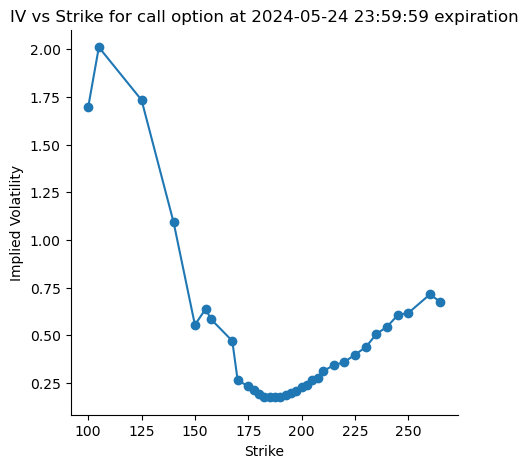

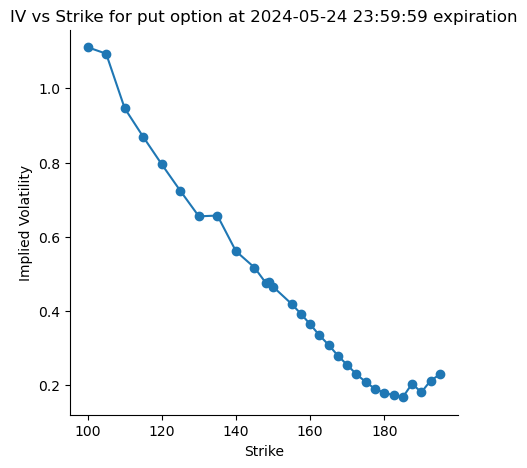

In [12]:
# Here an example call and put option expire at 2024-05-24 with. 
# We can observe a non-constant volatility(data from yfinance can't 100% reliable)
plot_vol_smile_intro('2024-05-24',"call")
plot_vol_smile_intro('2024-05-24',"put")

In [13]:
# We know that volatility isn't constant across different strikes. Now we want to investigate if there is disparities between 
# put and call volatility with the same caracteristics

def volatility_smile(ticker, expiration) :
    asset_ticker = yf.Ticker(ticker)
    S = asset_ticker.history(period="1d")["Close"].iloc[-1]
    
    # Filtering data to keep one expiration : 
    expiration = pd.to_datetime(expiration) \
    + pd.DateOffset(hours = 23, minutes = 59, seconds=59)
    plot_opt = option_def[(option_def["expiration"]==expiration)]
    plot_opt = plot_opt[["contractSymbol","strike","IV","opt_type","inTheMoney"]]
    plot_opt = plot_opt[(plot_opt["inTheMoney"]==True)] # Here for example if we want to compare only ITM options
    
    # Adding strike as percentage of spot price : 
    plot_opt["pct_strike"] = (plot_opt["strike"]/S)*100
    plot_opt = plot_opt.dropna()
    
    # Ploting data : 
    plt.figure(figsize=(5, 5))
    plt.plot(plot_opt["pct_strike"],plot_opt["IV"],"-o")
    plt.xlabel('Strike (as % of spot price)')
    plt.ylabel('Implied Volatility')
    plt.title(f"Volatility Smile {ticker} options {expiration}")
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()
    
    #print(plot_opt)
    #print("-----")
    #print(S)
    return None

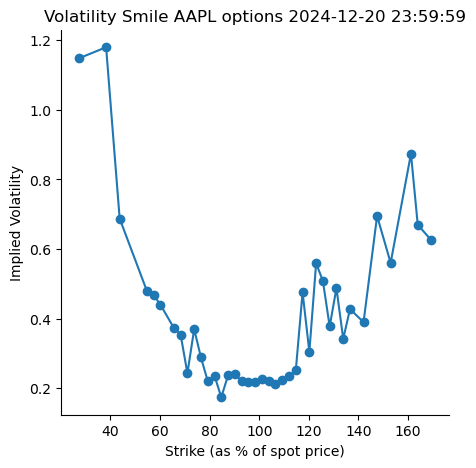

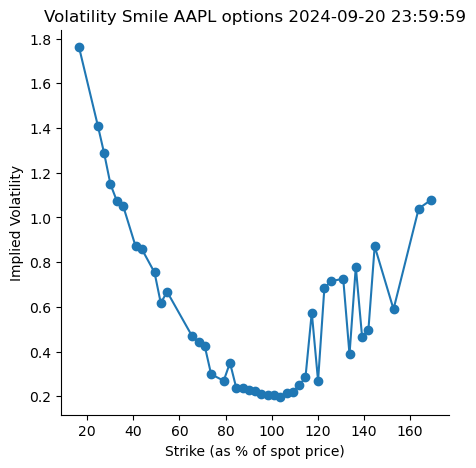

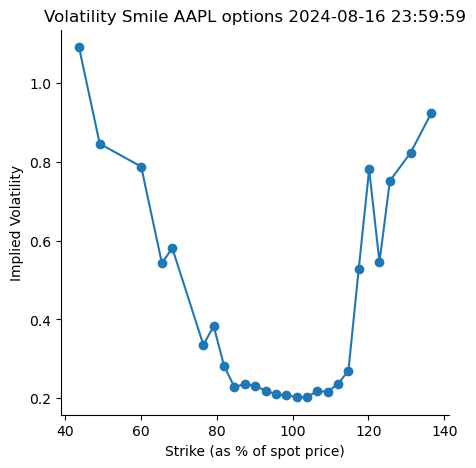

In [14]:
ticker ="AAPL"
volatility_smile(ticker, "2024-12-20")
volatility_smile(ticker, "2024-09-20")
volatility_smile(ticker, "2024-08-16")
# On the left side we can observe computed implied volatilty for ITM call, and on the right side the ITM puts. 

In [19]:
def volatility_surface() : 
    S = yf.Ticker(ticker).history(period="1d")["Close"].iloc[-1]
    
    # Adding strike as percentage of spot price and filtering : 
    vol_surface = option_def
    vol_surface["pct_strike"] = (option_def["strike"]/S)*100
    vol_surface = vol_surface[(vol_surface["inTheMoney"]==False)]
    
    vol_surface = vol_surface[["days_to_exp","pct_strike","IV"]]
    vol_surface = vol_surface.dropna()
    vol_surface["days_to_exp"] = vol_surface["days_to_exp"] * 365 # For easier lisibility 
    surface = (vol_surface.pivot_table(values='IV',index='pct_strike',columns="days_to_exp").dropna())
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111,projection='3d')
    x, y, z = surface.columns.values, surface.index.values, surface.values
    X, Y = np.meshgrid(x, y)
    
    ls = LightSource(270, 45)
    rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    plot = ax.plot_surface(X, Y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(plot, shrink=0.5, aspect=5)
    
    ax.set_xlabel('Days to expiration')
    ax.set_ylabel('Strike as % of spot')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Volatility Surface for ITM calls and puts')
    
    plt.show()
    
    return None
    
    

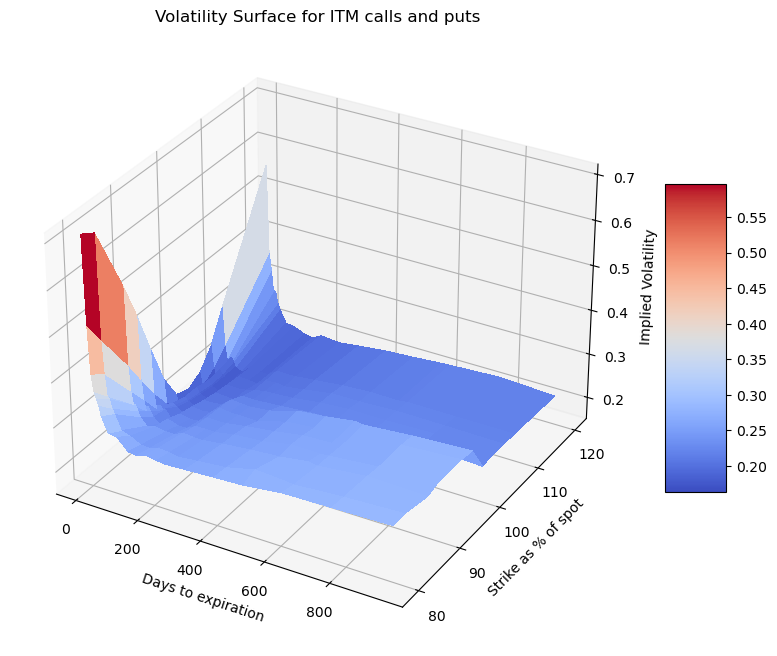

In [20]:
volatility_surface()

In [23]:
def volatility_surface_call() : 
    S = yf.Ticker(ticker).history(period="1d")["Close"].iloc[-1]
    
    # Adding strike as percentage of spot price and filtering : 
    vol_surface = option_def
    vol_surface["pct_strike"] = (option_def["strike"]/S)*100
    vol_surface = vol_surface[(vol_surface["opt_type"]=="call")]
    
    vol_surface = vol_surface[["days_to_exp","pct_strike","IV"]]
    vol_surface = vol_surface.dropna()
    vol_surface["days_to_exp"] = vol_surface["days_to_exp"] * 365 # For easier lisibility 
    surface = (vol_surface.pivot_table(values='IV',index='pct_strike',columns="days_to_exp").dropna())
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111,projection='3d')
    x, y, z = surface.columns.values, surface.index.values, surface.values
    X, Y = np.meshgrid(x, y)
    
    ls = LightSource(270, 45)
    rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    plot = ax.plot_surface(X, Y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(plot, shrink=0.5, aspect=5)
    
    ax.set_xlabel('Days to expiration')
    ax.set_ylabel('Strike as % of spot')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Volatility Surface for calls only')
    
    plt.show()
    
    return None

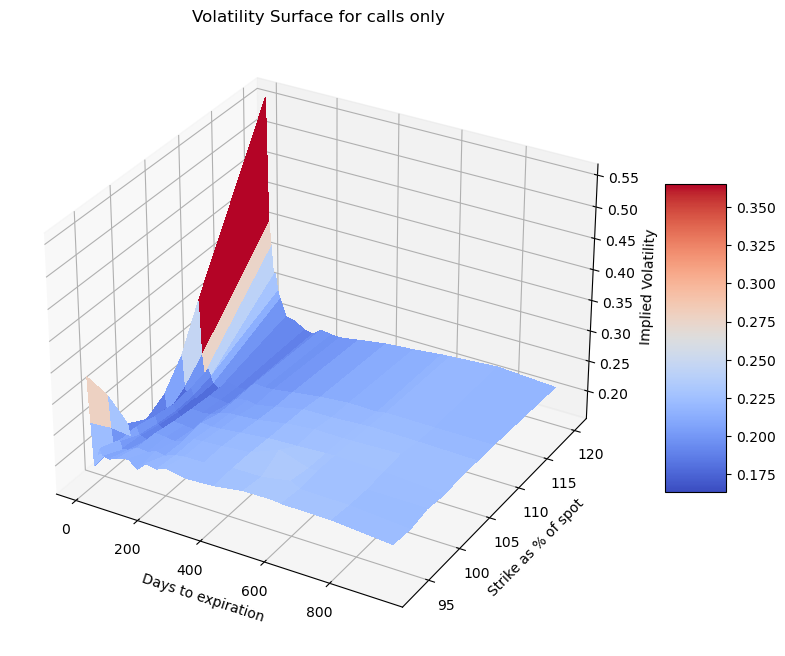

In [24]:
volatility_surface_call()

In [25]:
def volatility_surface_put() : 
    S = yf.Ticker(ticker).history(period="1d")["Close"].iloc[-1]
    
    # Adding strike as percentage of spot price and filtering : 
    vol_surface = option_def
    vol_surface["pct_strike"] = (option_def["strike"]/S)*100
    vol_surface = vol_surface[(vol_surface["opt_type"]=="put")]
    
    vol_surface = vol_surface[["days_to_exp","pct_strike","IV"]]
    vol_surface = vol_surface.dropna()
    vol_surface["days_to_exp"] = vol_surface["days_to_exp"] * 365 # For easier lisibility 
    surface = (vol_surface.pivot_table(values='IV',index='pct_strike',columns="days_to_exp").dropna())
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111,projection='3d')
    x, y, z = surface.columns.values, surface.index.values, surface.values
    X, Y = np.meshgrid(x, y)
    
    ls = LightSource(270, 45)
    rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    plot = ax.plot_surface(X, Y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(plot, shrink=0.5, aspect=5)
    
    ax.set_xlabel('Days to expiration')
    ax.set_ylabel('Strike as % of spot')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Volatility Surface for puts only')
    
    plt.show()
    
    return None

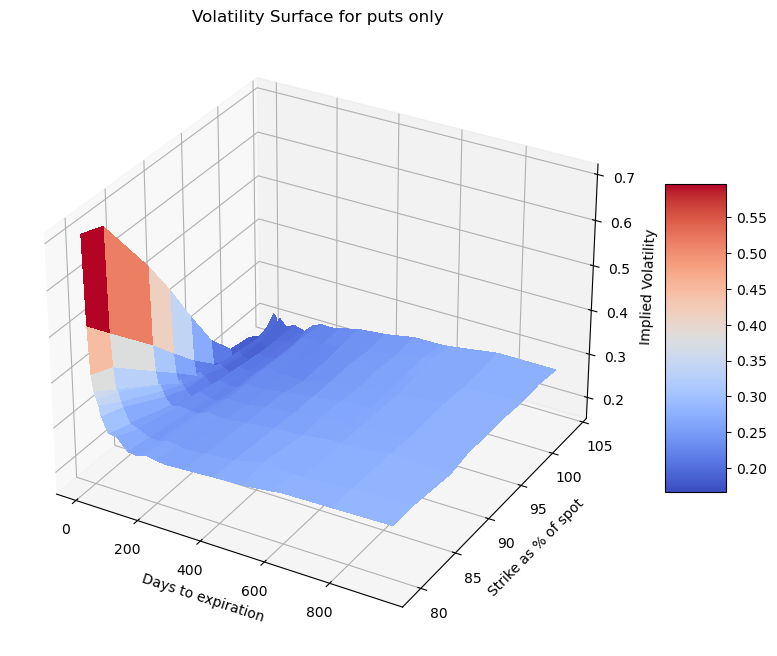

In [26]:
volatility_surface_put()